In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

In [6]:
file_path = 'cps09mar.xlsx'

df = pd.read_excel(file_path, engine='openpyxl')
df.rename(columns={'earnings': 'wage', 'hours': 'experience'}, inplace=True)
# 로그 임금 (ln_wage) 생성
df['ln_wage'] = np.log(df['wage'])

# age_squared_div_100 생성
df['age_squared_div_100'] = (df['age'] ** 2) / 100

# experience_squared_div_100 생성
df['experience_squared_div_100'] = (df['experience'] ** 2) / 100

# 독립 변수 리스트
independent_vars = ['age', 'age_squared_div_100', 'female', 'education', 'experience', 'experience_squared_div_100']
df.head()


,age,female,education,experience,wage,ln_wage,age_squared_div_100,experience_squared_div_100
0,52,0,12,45,146000,11.891362,27.04,20.25
1,38,0,18,45,50000,10.819778,14.44,20.25
2,38,0,14,40,32000,10.373491,14.44,16.00
3,41,1,13,40,47000,10.757903,16.81,16.00
4,42,0,13,50,161525,11.992415,17.64,25.00


In [7]:
# 독립 변수와 종속 변수 설정
X = df[independent_vars]
y = df['ln_wage']

# 상수항 추가 (절편)
X = sm.add_constant(X)

# 회귀 분석 결과 확인을 위해 변수 목록 출력
print(X.columns)

Index(['const', 'age', 'age_squared_div_100', 'female', 'education',
       'experience', 'experience_squared_div_100'],
      dtype='object')


In [8]:
# 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 결과 요약 출력
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                ln_wage   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     4300.
Date:                Sat, 12 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:30:45   Log-Likelihood:                -43570.
No. Observations:               50742   AIC:                         8.715e+04
Df Residuals:                   50735   BIC:                         8.722e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

회귀 결과 해석:  

Coefficients (계수): 각 독립 변수의 β 추정치 

Std Err (표준 오차): 각 계수의 표준 오차  

t (t-통계량): 계수 / 표준 오차  

P>|t| (p-값): t-통계량에 대한 p-값  

[0.025 0.975] (신뢰구간): 95% 신뢰구간  

$$
\theta = \frac{\beta_5}{\beta_6 + 2 \beta_7 \left(\frac{\text{Mean Experience}}{100}\right)}
$$
$\theta$ 는 위와 같이 정의

In [11]:
# 회귀 계수 추출
beta = model.params
beta_se = model.bse
cov_matrix = model.cov_params()

# 변수 추출
beta5 = beta['education']
beta6 = beta['experience']
beta7 = beta['experience_squared_div_100']

# 경험의 평균 계산
mean_experience = df['experience'].mean()

# θ 계산
D = beta6 + 2 * beta7 * (mean_experience / 100)
theta = beta5 / D

print(f"Theta (θ) = {theta}")


Theta (θ) = 4.3179277389534905


델타 방법을 이용해 $\theta$의 표준오차를 계산. 편미분 및 공분산 행렬을 사용

In [12]:
# 편미분 계산
partial_theta_beta5 = 1 / D
partial_theta_beta6 = -beta5 / (D ** 2)
partial_theta_beta7 = -2 * beta5 * (mean_experience / 100) / (D ** 2)

# 분산-공분산 행렬에서 필요한 공분산 추출
cov_beta5_beta6 = cov_matrix.loc['education', 'experience']
cov_beta5_beta7 = cov_matrix.loc['education', 'experience_squared_div_100']
cov_beta6_beta7 = cov_matrix.loc['experience', 'experience_squared_div_100']

# Var(theta) 계산
var_theta = (partial_theta_beta5 ** 2) * cov_matrix.loc['education', 'education'] + \
            (partial_theta_beta6 ** 2) * cov_matrix.loc['experience', 'experience'] + \
            (partial_theta_beta7 ** 2) * cov_matrix.loc['experience_squared_div_100', 'experience_squared_div_100'] + \
            2 * partial_theta_beta5 * partial_theta_beta6 * cov_beta5_beta6 + \
            2 * partial_theta_beta5 * partial_theta_beta7 * cov_beta5_beta7 + \
            2 * partial_theta_beta6 * partial_theta_beta7 * cov_beta6_beta7

# SE(theta) 계산
se_theta = np.sqrt(var_theta)

print(f"Theta (θ) = {theta}")
print(f"Standard Error of θ (SE(theta)) = {se_theta}")


Theta (θ) = 4.3179277389534905
Standard Error of θ (SE(theta)) = 0.11054968388715863


$\theta$의 추정치와 표준오차를 사용하여 $\theta$=0에 대한 가설을 검정

H0 = $\theta$ =0  
H1 = $\theta$ !=0

In [15]:
# t-통계량 계산
t_stat = theta / se_theta

# 자유도 계산
n = len(df)
k = len(independent_vars) + 1  # 상수항 포함
df_residual = n - k

# p-값 계산 (양측 검정) - scipy.stats 사용
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=df_residual))

print(f"\nt-statistic = {t_stat}")
print(f"p-value = {p_value}")

# 유의수준 설정 (예: 0.05)
alpha = 0.05

if p_value < alpha:
    print(f"\np-value ({p_value}) < alpha ({alpha}) → 귀무가설을 기각합니다.")
    print("θ가 0과 다르다고 주장할 수 있습니다.")
else:
    print(f"\np-value ({p_value}) ≥ alpha ({alpha}) → 귀무가설을 기각하지 못합니다.")
    print("θ가 0과 다르다고 주장할 수 없습니다.")



t-statistic = 39.058707244797986
p-value = 0.0

p-value (0.0) < alpha (0.05) → 귀무가설을 기각합니다.
θ가 0과 다르다고 주장할 수 있습니다.


t값이 매우 큰 탓에 t값이 매우 크게 나와 검정을 신뢰하기 힘들다. 

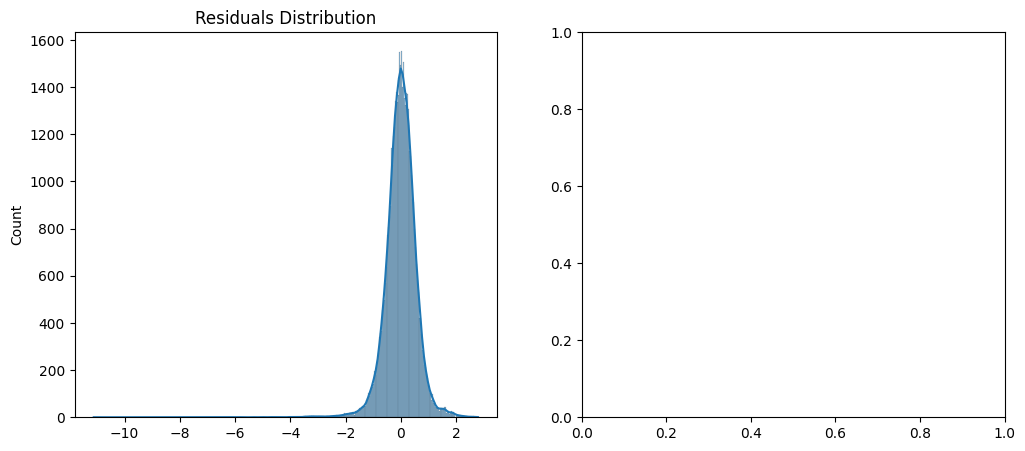

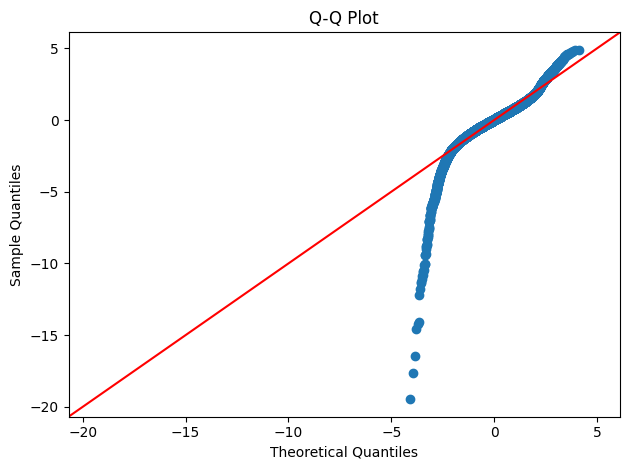

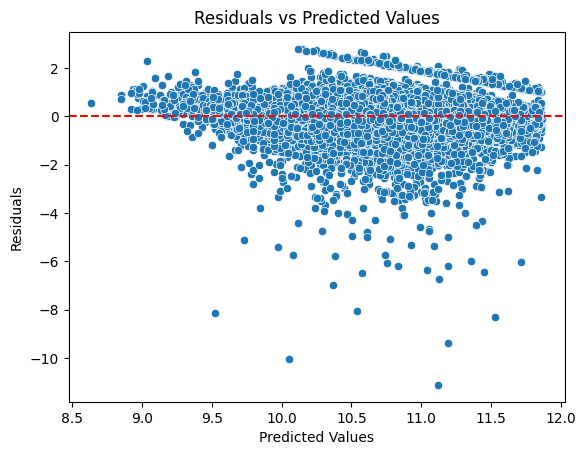

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 잔차 계산
residuals = model.resid

# 잔차의 정규성 확인 (히스토그램 및 Q-Q 플롯)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')

plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

# 잔차 vs. 예측값
sns.scatterplot(x=model.predict(), y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 독립 변수에 대한 VIF 계산 (상수항 제외)
X_vif = X.drop('const', axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)


                      feature         VIF
0                         age  527.279812
1         age_squared_div_100  171.994403
2                      female    1.782963
3                   education   27.884243
4                  experience  391.622581
5  experience_squared_div_100   85.697558


In [34]:
from scipy import stats

# t-통계량 대신 z-통계량 사용
z_stat = theta / se_theta

# p-값 계산 (양측 검정)
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"z-statistic = {z_stat}")
print(f"p-value = {p_value}")

# 유의수준 설정 (예: 0.05)
alpha = 0.05

if p_value < alpha:
    print(f"p-value ({p_value}) < alpha ({alpha}) → 귀무가설을 기각합니다.")
    print("θ가 0과 다르다고 주장할 수 있습니다.")
else:
    print(f"p-value ({p_value}) ≥ alpha ({alpha}) → 귀무가설을 기각하지 못합니다.")
    print("θ가 0과 다르다고 주장할 수 없습니다.")


z-statistic = 39.058707244797986
p-value = 0.0
p-value (0.0) < alpha (0.05) → 귀무가설을 기각합니다.
θ가 0과 다르다고 주장할 수 있습니다.
